In [1]:
from collections import defaultdict
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import pandas as pd
import seaborn as sns
import os

from howso.nominal_substitution.substitution_engine import NominalSubstitutionEngine
from howso.synthesizer import Synthesizer
from howso.utilities import infer_feature_attributes
from howso.validator import Validator
from howso.validator.results import ValidatorResult


os.environ["LANG"] = "en_US.UTF-8"
os.environ["LC_ALL"] = "en_US.UTF-8"

# Set this to True if the dataset is deemed to already have been anonymized.
ALREADY_ANONYMIZED: bool = True

In [2]:
col_type_mapping = {
    'nih_age': 'Int64', 'nih_alcohol_frequency': 'Int64', 'alcohol_drinksperday': 'Int64',
    'nih_sex': 'Int64', 'nih_asthma': 'Int64', 'nih_alc_sub_abuse': 'Int64', 'nih_autoimm': 'Int64',
    'nih_cancer_past_yr': 'Int64', 'nih_chronic_kidney_disease': 'Int64', 'nih_chronic_lung': 'Int64',
    'nih_copd': 'Int64', 'nih_cardiovascular_disease': 'Int64', 'nih_depression': 'Int64',
    'nih_diabetes': 'Int64', 'nih_hypertension': 'Int64', 'nih_immunocompromised': 'Int64',
    'nih_iv_drug_use': 'Int64', 'nih_other_chronic_cond': 'Int64', 'nih_mental_health_disorder': 'Int64',
    'nih_sickle_cell_disease': 'Int64', 'cov_pan_chal_hlth_2': 'Int64', 'cov_pan_chal_med_2': 'Int64',
    'cov_pan_chlng_trans_2': 'Int64', 'cov_tst_mthd_2': 'Int64', 'nih_abdom_pain': 'Int64',
    'nih_cough': 'Int64', 'nih_diff_breath': 'Int64', 'nih_fatigue': 'Int64', 'nih_fever_chills': 'Int64',
    'covid_had': 'Int64', 'nih_headache': 'Int64', 'nih_muscle_ache': 'Int64',
    'nih_nausea_vomiting_diarrhea': 'Int64', 'nih_olfactory': 'Int64', 'nih_other_symp': 'Int64',
    'covid_pandemic_challenges_abod_2': 'Int64', 'covid_pandemic_challenges_food_2': 'Int64',
    'covid_pandemic_challenges_wate_2': 'Int64', 'nih_throat_congestion_nose': 'Int64',
    'nih_skin_rash': 'Int64', 'covid_test_approval': 'Int64', 'covid_test_collection_setting': 'Int64',
    'covid_test_performed_location': 'Int64', 'covid_test_result': 'Int64',
    'covid_test_specimen_collector': 'Int64', 'covid_test_specimen_type': 'Int64',
    'covid_test_study_setting': 'Int64', 'covid_test_tar_dis_stat_2___1': 'Int64',
    'covid_test_tar_dis_stat_2___6': 'Int64', 'covid_test_type': 'Int64', 'covid_vaccine': 'Int64',
    'covid_vaccine_course': 'Int64', 'nih_employment': 'Int64', 'data_source': 'Int64', 'nih_education': 'Int64',
    'employed_ew': 'Int64', 'employed_healthcare_2': 'Int64', 'family_income': 'Int64',
    'fi_afford_balanced_meals': 'Int64', 'fi_change_diet': 'Int64', 'fi_change_diet_frequency': 'Int64',
    'fi_eat_less': 'Int64', 'fi_food_money_frequency': 'Int64', 'fi_high_quality_2': 'Int64',
    'fi_hungry': 'Int64', 'flu_vaccine_season_3': 'Int64', 'flu_vaccinehistind_2': 'Int64',
    'nih_insurance': 'Int64', 'hi_loss_covid': 'Int64', 'household_famgen_3': 'Int64',
    'household_homeless': 'Int64', 'housing_concerns': 'Int64', 'isolate_maintain_job': 'Int64',
    'jobloss_covid19_2': 'Int64', 'language_english': 'Int64', 'language_home___1': 'Int64',
    'language_home___5': 'Int64', 'language_home___6': 'Int64', 'language_home___7': 'Int64',
    'language_home___9': 'Int64', 'language_home___90': 'Int64', 'language_home___99': 'Int64',
    'nih_lifetime_use_alcohol': 'Int64', 'missed_procedure_2': 'Int64', 'positivemonth_covidtest_2': 'Int64',
    'positiveyear_covidtest_3': 'Int64', 'nih_pregnancy': 'Int64', 'quarantine_maintain_job': 'Int64',
    'race_ethn_asian_detail_3___1': 'Int64', 'race_ethn_asian_detail_3___2': 'Int64',
    'race_ethn_asian_detail_3___3': 'Int64', 'race_ethn_asian_detail_3___4': 'Int64',
    'race_ethn_asian_detail_3___5': 'Int64', 'nih_ethnicity': 'Int64',
    'race_ethn_hispanic_detail_2___1': 'Int64', 'race_ethn_hispanic_detail_2___2': 'Int64',
    'race_ethn_hispanic_detail_2___3': 'Int64', 'race_ethn_hispanic_detail_2___4': 'Int64',
    'race_ethn_islander_detail_2___1': 'Int64', 'race_ethn_islander_detail_2___10': 'Int64',
    'race_ethn_islander_detail_2___11': 'Int64', 'race_ethn_islander_detail_2___12': 'Int64',
    'race_ethn_islander_detail_2___13': 'Int64', 'race_ethn_islander_detail_2___2': 'Int64',
    'race_ethn_islander_detail_2___3': 'Int64', 'race_ethn_islander_detail_2___4': 'Int64',
    'race_ethn_islander_detail_2___5': 'Int64', 'race_ethn_islander_detail_2___6': 'Int64',
    'race_ethn_islander_detail_2___7': 'Int64', 'race_ethn_islander_detail_2___8': 'Int64',
    'race_ethn_islander_detail_2___9': 'Int64', 'recentmonth_covidtest_2': 'Int64',
    'recentresult_covidtest': 'Int64', 'recentyear_covidtest_3': 'Int64', 'nih_disability': 'Int64',
    'nih_health_status': 'Int64', 'smoke_years': 'float64', 'nih_history_smoking': 'Int64',
    'smoker_number': 'float64', 'stable_housing': 'Int64', 'take_presc_meds': 'Int64',
    'test_accesseasy_2': 'Int64', 'test_accesswhere_2': 'Int64', 'test_intent_2': 'Int64',
    'test_pbenearound_2': 'Int64', 'test_pbeneexposed_2': 'Int64', 'test_pbenepos_2': 'Int64',
    'test_pbenesafe_2': 'Int64', 'test_pbenework_2': 'Int64', 'test_pbeneworry_2': 'Int64',
    'test_percvaccuneg_2': 'Int64', 'test_percvaccupos_2': 'Int64', 'test_priskcontact_2': 'Int64',
    'test_priskknow_2': 'Int64', 'test_prisklater_2': 'Int64', 'test_prisknohelp_2': 'Int64',
    'test_prisknosymp_2': 'Int64', 'test_priskouch_2': 'Int64', 'test_resneg_2___1': 'Int64',
    'test_resneg_2___2': 'Int64', 'test_resneg_2___3': 'Int64', 'test_resneg_2___4': 'Int64',
    'test_respos_2___1': 'Int64', 'test_respos_2___2': 'Int64', 'test_respos_2___3': 'Int64',
    'tested_for_covid': 'Int64', 'tested_positive_for_covid': 'Int64', 'trust_coll_2': 'Int64',
    'trust_cortf_2': 'Int64', 'trust_doc_2': 'Int64', 'trust_fam_2': 'Int64', 'trust_flead_2': 'Int64',
    'trust_news_2': 'Int64', 'trust_social_2': 'Int64', 'trust_usgov_2': 'Int64', 'vaccine_avail': 'Int64',
    'vaccine_concerns_3___1': 'Int64', 'vaccine_concerns_3___10': 'Int64', 'vaccine_concerns_3___2': 'Int64',
    'vaccine_concerns_3___3': 'Int64', 'vaccine_concerns_3___4': 'Int64', 'vaccine_concerns_3___5': 'Int64',
    'vaccine_concerns_3___6': 'Int64', 'vaccine_concerns_3___7': 'Int64', 'vaccine_concerns_3___8': 'Int64',
    'vaccine_concerns_3___9': 'Int64', 'vaccine_reasons_3___1': 'Int64', 'vaccine_reasons_3___2': 'Int64',
    'vaccine_reasons_3___3': 'Int64', 'vaccine_reasons_3___4': 'Int64', 'vaccine_reasons_3___5': 'Int64',
    'vaccine_reasons_3___6': 'Int64', 'vaccine_reasons_3___7': 'Int64', 'vaccine_reasons_3___8': 'Int64',
    'vaccine_reasons_3___9': 'Int64', 'nih_vape_freq': 'Int64', 'vaper_years': 'float64',
    'work_closecont_2': 'Int64', 'work_ppe_2': 'Int64', 'work_wash_2': 'Int64', 'nih_zip': 'string',
    'nih_weight': 'Int64', 'nih_height': 'Int64', 'nih_race': 'Int64', 'nih_alcohol_yn': 'Int64',
    'nih_cig_smoke_freq': 'Int64', 'nih_smoking_yn': 'Int64'
    }
print(f'total number of columns being mapped: {len(col_type_mapping)}')

data_path = Path("/home", "sagemaker-user", "phs002526", "project26_DATA_transformcopy_v3_processed.csv")
df = pd.read_csv(data_path, dtype=col_type_mapping)
print(f'initial input data shape: {df.shape}')
df = df.reset_index(drop=True)
print(f'input data shape after reset_index: {df.shape}')
print(df.columns)

# for model comparison for covid_test_result prediction, nulls from target feature should be removed and all-null columns should be removed as well
target_feature = 'tested_for_covid'
df = df.dropna(subset=[target_feature])
print('input data shape after dropna target feature: {df.shape}')
df = df[(df[target_feature] != 98) & (df[target_feature] != 99)]
print(f'after removing null and extraneous rows, df.shape: {df.shape}')
null_only_cols = df.columns[df.isna().all()].tolist()
print(f'null-only columns: {null_only_cols}')
df = df.drop(columns=null_only_cols)
df = df.drop(columns='index')
df = df.reset_index(drop=True)
print(f'input dataframe shape after processing: {df.shape}')
print(df[target_feature].value_counts())
df.to_csv(f'{os.path.splitext(data_path)[0]}_{target_feature}.csv', index=False)
pd.set_option('display.max_columns', None)
df.describe()

total number of columns being mapped: 187
initial input data shape: (23111, 188)
input data shape after reset_index: (23111, 188)
Index(['index', 'nih_age', 'nih_alcohol_frequency', 'alcohol_drinksperday',
       'nih_sex', 'nih_asthma', 'nih_alc_sub_abuse', 'nih_autoimm',
       'nih_cancer_past_yr', 'nih_chronic_kidney_disease',
       ...
       'work_closecont_2', 'work_ppe_2', 'work_wash_2', 'nih_zip',
       'nih_weight', 'nih_height', 'nih_race', 'nih_alcohol_yn',
       'nih_cig_smoke_freq', 'nih_smoking_yn'],
      dtype='object', length=188)
input data shape after dropna target feature: {df.shape}
after removing null and extraneous rows, df.shape: (4753, 188)
null-only columns: ['covid_test_approval', 'covid_test_collection_setting', 'covid_test_performed_location', 'covid_test_result', 'covid_test_specimen_collector', 'covid_test_specimen_type', 'covid_test_study_setting', 'covid_test_tar_dis_stat_2___1', 'covid_test_tar_dis_stat_2___6', 'covid_test_type', 'race_ethn_islande

,nih_age,nih_alcohol_frequency,alcohol_drinksperday,nih_sex,nih_asthma,nih_alc_sub_abuse,nih_autoimm,nih_cancer_past_yr,nih_chronic_kidney_disease,nih_chronic_lung,nih_copd,nih_cardiovascular_disease,nih_depression,nih_diabetes,nih_hypertension,nih_immunocompromised,nih_iv_drug_use,nih_other_chronic_cond,nih_mental_health_disorder,nih_sickle_cell_disease,cov_pan_chal_hlth_2,cov_pan_chal_med_2,cov_pan_chlng_trans_2,cov_tst_mthd_2,nih_abdom_pain,nih_cough,nih_diff_breath,nih_fatigue,nih_fever_chills,covid_had,nih_headache,nih_muscle_ache,nih_nausea_vomiting_diarrhea,nih_olfactory,nih_other_symp,covid_pandemic_challenges_abod_2,covid_pandemic_challenges_food_2,covid_pandemic_challenges_wate_2,nih_throat_congestion_nose,nih_skin_rash,covid_vaccine,covid_vaccine_course,nih_employment,data_source,nih_education,employed_ew,employed_healthcare_2,family_income,fi_afford_balanced_meals,fi_change_diet,fi_change_diet_frequency,fi_eat_less,fi_food_money_frequency,fi_high_quality_2,fi_hungry,flu_vaccine_season_3,flu_vaccinehistind_2,nih_insurance,hi_loss_covid,household_famgen_3,household_homeless,housing_concerns,isolate_maintain_job,jobloss_covid19_2,language_english,language_home___1,language_home___5,language_home___6,language_home___7,language_home___9,language_home___90,language_home___99,nih_lifetime_use_alcohol,missed_procedure_2,positivemonth_covidtest_2,positiveyear_covidtest_3,nih_pregnancy,quarantine_maintain_job,race_ethn_asian_detail_3___1,race_ethn_asian_detail_3___2,race_ethn_asian_detail_3___3,race_ethn_asian_detail_3___4,race_ethn_asian_detail_3___5,nih_ethnicity,race_ethn_hispanic_detail_2___1,race_ethn_hispanic_detail_2___2,race_ethn_hispanic_detail_2___3,race_ethn_hispanic_detail_2___4,race_ethn_islander_detail_2___1,race_ethn_islander_detail_2___10,race_ethn_islander_detail_2___11,race_ethn_islander_detail_2___12,race_ethn_islander_detail_2___2,race_ethn_islander_detail_2___3,race_ethn_islander_detail_2___4,race_ethn_islander_detail_2___5,race_ethn_islander_detail_2___6,recentmonth_covidtest_2,recentresult_covidtest,recentyear_covidtest_3,nih_disability,nih_health_status,smoke_years,nih_history_smoking,smoker_number,stable_housing,take_presc_meds,test_accesseasy_2,test_accesswhere_2,test_intent_2,test_pbenearound_2,test_pbeneexposed_2,test_pbenepos_2,test_pbenesafe_2,test_pbenework_2,test_pbeneworry_2,test_percvaccuneg_2,test_percvaccupos_2,test_priskcontact_2,test_priskknow_2,test_prisklater_2,test_prisknohelp_2,test_prisknosymp_2,test_priskouch_2,test_resneg_2___1,test_resneg_2___2,test_resneg_2___3,test_resneg_2___4,test_respos_2___1,test_respos_2___2,test_respos_2___3,tested_for_covid,tested_positive_for_covid,trust_coll_2,trust_cortf_2,trust_doc_2,trust_fam_2,trust_flead_2,trust_news_2,trust_social_2,trust_usgov_2,vaccine_avail,vaccine_concerns_3___1,vaccine_concerns_3___10,vaccine_concerns_3___2,vaccine_concerns_3___3,vaccine_concerns_3___4,vaccine_concerns_3___5,vaccine_concerns_3___6,vaccine_concerns_3___7,vaccine_concerns_3___8,vaccine_concerns_3___9,vaccine_reasons_3___1,vaccine_reasons_3___2,vaccine_reasons_3___3,vaccine_reasons_3___4,vaccine_reasons_3___5,vaccine_reasons_3___6,vaccine_reasons_3___7,vaccine_reasons_3___8,vaccine_reasons_3___9,nih_vape_freq,vaper_years,work_closecont_2,work_ppe_2,work_wash_2,nih_weight,nih_height,nih_race,nih_alcohol_yn,nih_cig_smoke_freq,nih_smoking_yn
count,4739.0,3436.0,1981.0,3358.0,3760.0,3753.0,3742.0,3758.0,3504.0,3504.0,3760.0,3760.0,3825.0,3742.0,3742.0,3760.0,3743.0,3768.0,3779.0,3742.0,2853.0,2853.0,2849.0,2684.0,131.0,282.0,85.0,248.0,130.0,3948.0,238.0,120.0,113.0,14.0,1387.0,2853.0,2853.0,2851.0,102.0,50.0,4600.0,376.0,4387.0,805.0,2921.0,1973.0,469.0,4430.0,4382.0,4349.0,1043.0,944.0,4351.0,4231.0,4344.0,1481.0,2161.0,4353.0,4291.0,2348.0,45.0,4280.0,2055.0,3044.0,1119.0,10.0,7.0,17.0,8.0,3313.0,44.0,3313.0,3436.0,4274.0,418.0,25.0,1350.0,4533.0,602.0,752.0,687.0,105.0,3.0,51.0,5.0,5.0,5.0,5.0,1681.0,3.0,1.0,2.0,216.0,104.0,15.0,3.0,1.0,3173.0,3451.0,137.0,4545

In [3]:
continuous_feats: list[str] = [
    'nih_height', 'nih_age', 'vaper_years', 'smoke_years', 'nih_weight', 'smoker_number'
]

# These features have been decided to be personally-identifying and, if they
# have not already been anonymized, will be replaced with novel nominals.
sensitive_nominal_feats: dict[str, str] = {
    "nih_zip": "int-id"
}

# These are non-personally-identifying nominals. Their values may be present in
# the resulting synthetic data, but necessary to maintain the predictiveness of
# the resulting synthetic data.
nominal_feats = list(set(df.columns) - set(continuous_feats) - set(sensitive_nominal_feats.keys()))
print(nominal_feats)

['take_presc_meds', 'nih_sex', 'language_home___90', 'race_ethn_hispanic_detail_2___4', 'work_wash_2', 'quarantine_maintain_job', 'race_ethn_asian_detail_3___4', 'race_ethn_islander_detail_2___1', 'race_ethn_asian_detail_3___3', 'tested_for_covid', 'fi_hungry', 'test_prisknohelp_2', 'covid_pandemic_challenges_abod_2', 'vaccine_concerns_3___1', 'nih_insurance', 'nih_depression', 'nih_chronic_kidney_disease', 'employed_ew', 'nih_skin_rash', 'jobloss_covid19_2', 'nih_nausea_vomiting_diarrhea', 'recentresult_covidtest', 'test_pbenesafe_2', 'vaccine_reasons_3___1', 'trust_fam_2', 'employed_healthcare_2', 'isolate_maintain_job', 'nih_ethnicity', 'test_pbenepos_2', 'household_famgen_3', 'vaccine_concerns_3___9', 'test_resneg_2___1', 'cov_pan_chal_hlth_2', 'test_respos_2___1', 'trust_cortf_2', 'fi_high_quality_2', 'language_home___7', 'positiveyear_covidtest_3', 'nih_vape_freq', 'race_ethn_hispanic_detail_2___3', 'nih_lifetime_use_alcohol', 'nih_copd', 'race_ethn_asian_detail_3___2', 'test_pbe

In [4]:
# Compute feature attributes
features = infer_feature_attributes(
    df,
    types={
        "continuous": continuous_feats,
        "nominal": list(sensitive_nominal_feats.keys()) + nominal_feats
    },
    # Let's use tight-bounds for the continuous
    tight_bounds=continuous_feats,
)

# Non-sensitive nominals should be marked as such
for nominal in nominal_feats:
    features[nominal]["non_sensitive"] = True

if ALREADY_ANONYMIZED:
    # If data is already anonymized, mark the "sensitive" features non-sensitive too.
    for nominal in sensitive_nominal_feats.keys():
        features[nominal]["non_sensitive"] = True
else:
    # Let's mark the sensitive nominals with the desired subtypes
    for nominal, subtype in sensitive_nominal_feats.items():
        features[nominal]["subtype"] = subtype

features.to_dataframe()


type decimal_places bounds                   \
                                                    min   max allow_null   
nih_age                continuous            0.0    5.0  89.0       True   
nih_alcohol_frequency     nominal            0.0    NaN   NaN       True   
alcohol_drinksperday      nominal            0.0    NaN   NaN       True   
nih_sex                   nominal            0.0    NaN   NaN       True   
nih_asthma                nominal            0.0    NaN   NaN       True   
...                           ...            ...    ...   ...        ...   
nih_height             continuous            0.0   38.0  81.0       True   
nih_race                  nominal            0.0    NaN   NaN       True   
nih_alcohol_yn            nominal            0.0    NaN   NaN       True   
nih_cig_smoke_freq        nominal            0.0    NaN   NaN       True   
nih_smoking_yn            nominal            0.0    NaN   NaN       True   

                                                data_type non_sensitive  \
                      observed_min observed_max                           
nih_age                        5.0         89.0    number           NaN   
nih_alcohol_frequency          NaN          NaN    number          True   
alcohol_drinksperday           NaN          NaN    number          True   
nih_sex                        NaN          NaN    number          True   
nih_asthma                     NaN          NaN    number          True   
...                            ...          ...       ...           ...   
nih_height                    38.0         81.0    number           NaN   
nih_race                       NaN          NaN    number          True   
nih_alcohol_yn                 NaN          NaN    number          True   
nih_cig_smoke_freq             NaN          NaN    number          True   
nih_smoking_yn                 NaN          NaN    number          True   

                      original_type       
                          data_type size  
nih_age                     integer  8.0  
nih_alcohol_frequency       integer  8.0  
alcohol_drinksperday        integer  8.0  
nih_sex                     integer  8.0  
nih_asthma                  integer  8.0  
...                             ...  ...  
nih_height                  integer  8.0  
nih_race                    integer  8.0  
nih_alcohol_yn              integer  8.0  
nih_cig_smoke_freq          integer  8.0  
nih_smoking_yn              integer  8.0  

[173 rows x 11 columns]

In [5]:
if not ALREADY_ANONYMIZED:
    # Before continuing, let's substitute sensitive features with replacement nominals.

    # Instantiate the NominalSubstitutionEngine
    substitution_engine = NominalSubstitutionEngine.factory(nominal_substitution_config={
        "nominals": {"default": {"locales": ["en_US"], "substitution": "naive"}},
    })
    df = substitution_engine.apply_substitutions(features, df)

    # Now that these replacements have been made, we no longer need these marked as sensitive.
    for feature in sensitive_nominal_feats.keys():
        features[feature]["subtype"] = None
        features[feature]["non_sensitive"] = True

    # Display the new dataframe and feature attributes
    display(df)
    display(features.to_dataframe())


In [7]:
desired_conviction_list = [0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 25.0]
synthed_dfs: list[pd.DataFrame] = []
validator_results: list[ValidatorResult] = []
metrics = [
    # This provides a privacy metric
    "AnonymityPreservation",
    # These are the 3 most typical used for Accuracy metrics
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",   # This will give us more detailed, per-feature accuracy metrics.
]

# Move desired_conviction loop out to the top so that we don't re-train the
# same trainee over and over.
for desired_conviction in desired_conviction_list:
    display(Markdown(f"## Processing desired_conviction={desired_conviction}"))

    with Synthesizer(privacy_override=True, use_id_privacy=False) as s:
        s.train(df, features=features)

        synth_df = s.synthesize_cases(
            n_samples=df.shape[0],
            desired_conviction=desired_conviction,
            # generate_new_cases="always"
            generate_new_cases="no"
        )
        synthed_dfs.append(synth_df)
        synth_df.to_csv(f'data/phs002526/{target_feature}/gen_new_case_no/synthesized_{desired_conviction}.csv', 
                        index=False)
        with Validator(s, synth_df) as v:
            results = v.run_metrics(metrics)
        validator_results.append(results)

## Processing desired_conviction=0.1

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=3.402
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.637
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=0.142
Run finished with overall_desirability=1.722


## Processing desired_conviction=0.5

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=3.388
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.134
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=1.251
Run finished with overall_desirability=3.059


## Processing desired_conviction=1.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.281
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.947
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=3.666
Run finished with overall_desirability=4.195


## Processing desired_conviction=3.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.758
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.336
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.369
Run finished with overall_desirability=4.608


## Processing desired_conviction=5.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.474
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.491
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.525
Run finished with overall_desirability=4.618


## Processing desired_conviction=10.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.4
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.578
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.555
Run finished with overall_desirability=4.628


## Processing desired_conviction=25.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,753 x 173) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.348
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.635
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.613
Run finished with overall_desirability=4.643


In [8]:
# Display the full metric details for each desirability_conviction level
for desired_conviction, synth_df, results in zip(desired_conviction_list, synthed_dfs, validator_results, strict=True):
    display(Markdown(f"## {desired_conviction=}"))
    for metric_name, result in results.items():
        display(metric_name)
        display(result.get_dataframe())

## desired_conviction=0.1

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,33.222529,6.433529,1.020341,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_nausea_vomiting_diarrhea,mode,1.0,NaN
1,1,generated,nih_nausea_vomiting_diarrhea,mode,1.0,NaN
2,1,original,nih_nausea_vomiting_diarrhea,uniques,1.0,5.0
3,1,generated,nih_nausea_vomiting_diarrhea,uniques,1.0,5.0
4,1,original,nih_nausea_vomiting_diarrhea,entropy,0.0,5.0
...,...,...,...,...,...,...
1117,1,generated,language_home___1,mode,1.0,NaN
1118,1,original,language_home___1,uniques,1.0,5.0
1119,1,generated,language_home___1,uniques,1.0,5.0
1120,1,original,language_home___1,entropy,0.0,5.0


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.272619,3.637


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_nausea_vomiting_diarrhea,None,NaN,NaN
1,1,NaN,Howso,nih_other_symp,None,NaN,NaN
2,1,NaN,Howso,nih_headache,None,NaN,NaN
3,1,NaN,Howso,nih_throat_congestion_nose,None,NaN,NaN
4,1,NaN,Howso,test_respos_2___2,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,nih_iv_drug_use,mcc,0.000000,5.00
978,1,original,Howso,nih_iv_drug_use,recall,0.796004,0.03
979,1,generated,Howso,nih_iv_drug_use,recall,0.004206,0.03
980,1,original,Howso,nih_iv_drug_use,precision,0.633623,0.03


## desired_conviction=0.5

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,12.437469,3.839501,1.021908,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,race_ethn_asian_detail_3___4,mode,1.0,NaN
1,1,generated,race_ethn_asian_detail_3___4,mode,1.0,NaN
2,1,original,race_ethn_asian_detail_3___4,uniques,1.0,5.000000
3,1,generated,race_ethn_asian_detail_3___4,uniques,1.0,5.000000
4,1,original,race_ethn_asian_detail_3___4,entropy,0.0,5.000000
...,...,...,...,...,...,...
1117,1,generated,trust_usgov_2,mode,4.0,NaN
1118,1,original,trust_usgov_2,uniques,5.0,5.000000
1119,1,generated,trust_usgov_2,uniques,5.0,5.000000
1120,1,original,trust_usgov_2,entropy,1.333603,4.140401


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.17326,4.134


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,race_ethn_asian_detail_3___4,None,NaN,NaN
1,1,NaN,Howso,race_ethn_asian_detail_3___1,None,NaN,NaN
2,1,NaN,Howso,race_ethn_asian_detail_3___2,None,NaN,NaN
3,1,NaN,Howso,vaccine_concerns_3___4,None,NaN,NaN
4,1,NaN,Howso,test_resneg_2___2,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,trust_usgov_2,mcc,0.035510,0.830
978,1,original,Howso,trust_usgov_2,recall,0.419558,2.456
979,1,generated,Howso,trust_usgov_2,recall,0.242902,2.456
980,1,original,Howso,trust_usgov_2,precision,0.344972,0.487


## desired_conviction=1.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,5.781751,1.394253,1.062718,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,test_resneg_2___1,mode,1.0,NaN
1,1,generated,test_resneg_2___1,mode,1.0,NaN
2,1,original,test_resneg_2___1,uniques,1.0,5.000000
3,1,generated,test_resneg_2___1,uniques,1.0,5.000000
4,1,original,test_resneg_2___1,entropy,0.0,5.000000
...,...,...,...,...,...,...
1117,1,generated,fi_high_quality_2,mode,2.0,NaN
1118,1,original,fi_high_quality_2,uniques,5.0,5.000000
1119,1,generated,fi_high_quality_2,uniques,5.0,5.000000
1120,1,original,fi_high_quality_2,entropy,1.338278,4.972791


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.21051,3.947


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,test_resneg_2___1,None,NaN,NaN
1,1,NaN,Howso,nih_diff_breath,None,NaN,NaN
2,1,NaN,Howso,vaccine_concerns_3___2,None,NaN,NaN
3,1,NaN,Howso,take_presc_meds,None,NaN,NaN
4,1,NaN,Howso,vaccine_reasons_3___2,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,fi_high_quality_2,mcc,0.006610,0.993
978,1,original,Howso,fi_high_quality_2,recall,0.390116,4.168
979,1,generated,Howso,fi_high_quality_2,recall,0.330179,4.168
980,1,original,Howso,fi_high_quality_2,precision,0.338881,3.946


## desired_conviction=3.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,3.252751,0.765276,1.122812,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,test_prisknohelp_2,mode,0.0,NaN
1,1,generated,test_prisknohelp_2,mode,0.0,NaN
2,1,original,test_prisknohelp_2,uniques,5.0,5.000000
3,1,generated,test_prisknohelp_2,uniques,5.0,5.000000
4,1,original,test_prisknohelp_2,entropy,1.420157,4.768322
...,...,...,...,...,...,...
1117,1,generated,nih_asthma,mode,0.0,NaN
1118,1,original,nih_asthma,uniques,2.0,5.000000
1119,1,generated,nih_asthma,uniques,2.0,5.000000
1120,1,original,nih_asthma,entropy,0.282134,4.566292


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.132778,4.336


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,language_home___1,None,NaN,NaN
1,1,NaN,Howso,take_presc_meds,None,NaN,NaN
2,1,NaN,Howso,vaccine_concerns_3___10,None,NaN,NaN
3,1,NaN,Howso,vaccine_reasons_3___9,None,NaN,NaN
4,1,NaN,Howso,nih_headache,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,nih_asthma,mcc,0.000000,3.415
978,1,original,Howso,nih_asthma,recall,0.717140,5.000
979,1,generated,Howso,nih_asthma,recall,0.717140,5.000
980,1,original,Howso,nih_asthma,precision,0.545112,4.684


## desired_conviction=5.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,2.83933,0.449666,1.140226,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,trust_social_2,mode,2.0,NaN
1,1,generated,trust_social_2,mode,2.0,NaN
2,1,original,trust_social_2,uniques,5.0,5.000000
3,1,generated,trust_social_2,uniques,5.0,5.000000
4,1,original,trust_social_2,entropy,1.430866,4.876669
...,...,...,...,...,...,...
1117,1,generated,nih_insurance,mode,1.0,NaN
1118,1,original,nih_insurance,uniques,4.0,5.000000
1119,1,generated,nih_insurance,uniques,4.0,5.000000
1120,1,original,nih_insurance,entropy,0.971969,4.577408


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.101752,4.491


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,vaccine_concerns_3___10,None,NaN,NaN
1,1,NaN,Howso,vaccine_reasons_3___1,None,NaN,NaN
2,1,NaN,Howso,nih_cough,None,NaN,NaN
3,1,NaN,Howso,test_respos_2___2,None,NaN,NaN
4,1,NaN,Howso,race_ethn_islander_detail_2___3,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,nih_insurance,mcc,0.267234,4.093
978,1,original,Howso,nih_insurance,recall,0.605678,4.734
979,1,generated,Howso,nih_insurance,recall,0.577287,4.734
980,1,original,Howso,nih_insurance,precision,0.548358,4.658


## desired_conviction=10.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,2.702807,0.626494,1.150239,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_skin_rash,mode,1.0,NaN
1,1,generated,nih_skin_rash,mode,1.0,NaN
2,1,original,nih_skin_rash,uniques,1.0,5.0
3,1,generated,nih_skin_rash,uniques,1.0,5.0
4,1,original,nih_skin_rash,entropy,0.0,5.0
...,...,...,...,...,...,...
1117,1,generated,test_respos_2___3,mode,1.0,NaN
1118,1,original,test_respos_2___3,uniques,1.0,5.0
1119,1,generated,test_respos_2___3,uniques,1.0,5.0
1120,1,original,test_respos_2___3,entropy,0.0,5.0


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.084391,4.578


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_skin_rash,None,NaN,NaN
1,1,NaN,Howso,vaccine_reasons_3___1,None,NaN,NaN
2,1,NaN,Howso,nih_muscle_ache,None,NaN,NaN
3,1,NaN,Howso,nih_nausea_vomiting_diarrhea,None,NaN,NaN
4,1,NaN,Howso,language_home___1,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,trust_usgov_2,mcc,0.163987,4.613
978,1,original,Howso,trust_usgov_2,recall,0.400631,4.891
979,1,generated,Howso,trust_usgov_2,recall,0.392219,4.891
980,1,original,Howso,trust_usgov_2,precision,0.329959,4.951


## desired_conviction=25.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,2.683749,0.626429,1.155433,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,test_respos_2___2,mode,1.0,NaN
1,1,generated,test_respos_2___2,mode,1.0,NaN
2,1,original,test_respos_2___2,uniques,1.0,5.000000
3,1,generated,test_respos_2___2,uniques,1.0,5.000000
4,1,original,test_respos_2___2,entropy,0.0,5.000000
...,...,...,...,...,...,...
1117,1,generated,work_closecont_2,mode,2.0,NaN
1118,1,original,work_closecont_2,uniques,5.0,5.000000
1119,1,generated,work_closecont_2,uniques,5.0,5.000000
1120,1,original,work_closecont_2,entropy,1.371816,4.838084


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.073011,4.635


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,test_respos_2___2,None,NaN,NaN
1,1,NaN,Howso,language_home___7,None,NaN,NaN
2,1,NaN,Howso,take_presc_meds,None,NaN,NaN
3,1,NaN,Howso,vaccine_concerns_3___5,None,NaN,NaN
4,1,NaN,Howso,vaccine_reasons_3___4,None,NaN,NaN
...,...,...,...,...,...,...,...
977,1,generated,Howso,work_closecont_2,mcc,0.090697,4.560
978,1,original,Howso,work_closecont_2,recall,0.170347,4.857
979,1,generated,Howso,work_closecont_2,recall,0.176656,4.857
980,1,original,Howso,work_closecont_2,precision,0.080657,4.800


In [9]:
# Create a summary DataFrame
final_result = pd.DataFrame()
data: dict[str, list] = defaultdict(list)

for desired_conviction, validator_result in zip(desired_conviction_list, validator_results):
    data["desired_conviction"].append(desired_conviction)
    for metric in metrics:
        data[metric].append(validator_result[metric].desirability)

final_result = pd.DataFrame(data)

display(final_result)


,desired_conviction,AnonymityPreservation,DescriptiveStatistics,JointProbability,ModelComparison
0,0.1,5.0,3.402,3.637,0.142
1,0.5,5.0,3.388,4.134,1.251
2,1.0,5.0,4.281,3.947,3.666
3,3.0,5.0,4.758,4.336,4.369
4,5.0,5.0,4.474,4.491,4.525
5,10.0,5.0,4.400,4.578,4.555
6,25.0,5.0,4.348,4.635,4.613


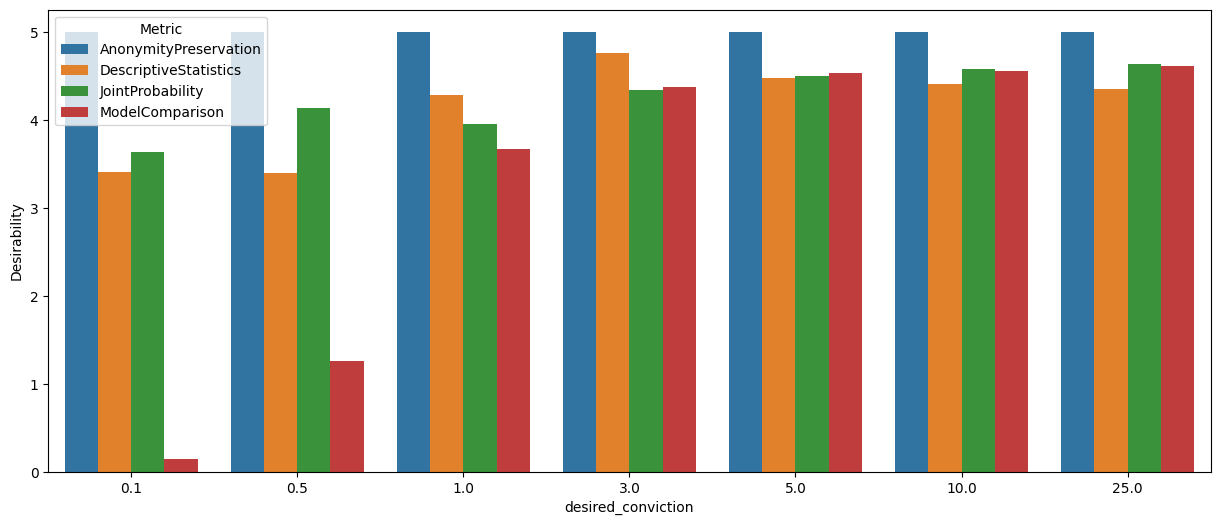

In [10]:
import matplotlib.pyplot as plt

# Melt the dataframe to long format
melted_df = final_result.melt(
    id_vars="desired_conviction",
    value_vars=metrics,
    var_name="Metric",
    value_name="Desirability"
)

# Create grouped bar chart
plt.figure(figsize=(15, 6))
sns.barplot(data=melted_df, x="desired_conviction", y="Desirability", hue="Metric")
plt.show()

nih_age Int64 5 89
smoke_years float64 1.0 50.0
smoker_number float64 1.0 27.0
vaper_years float64 4.0 16.0


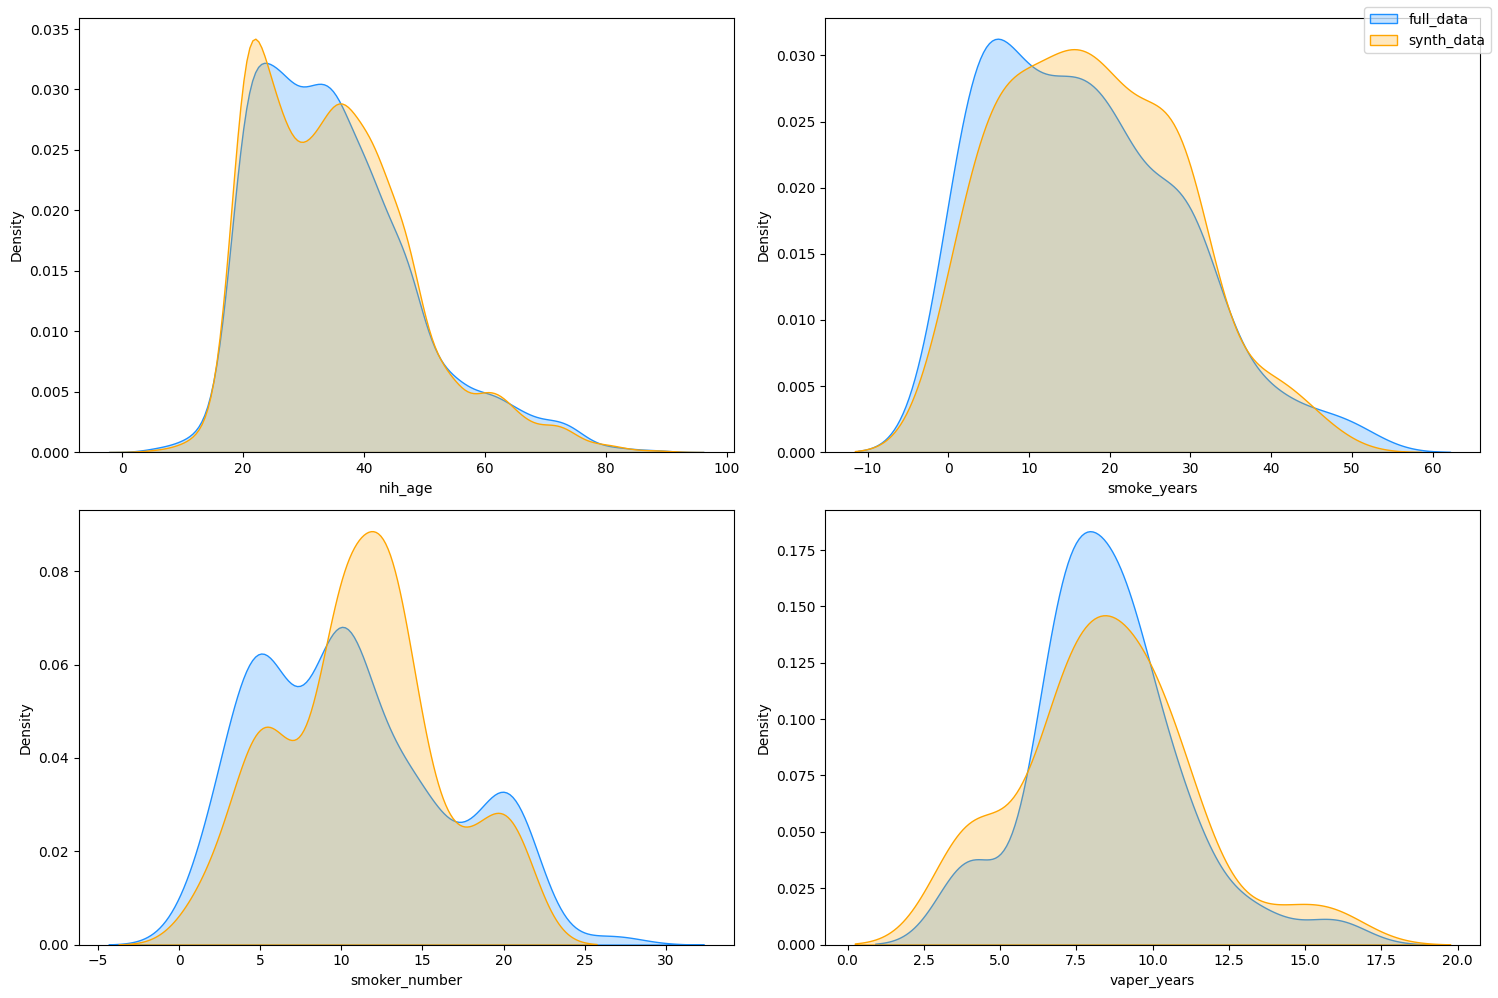

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]

gen_df = synthed_dfs[-1]  # Using the one with the highest accuracy (theoretically)

for c, ax in zip(df.columns.drop(categorical_features), axes.flat):
    print(c, df[c].dtypes, df[c].min(), df[c].max())
    if df[c].dtypes != 'string':
        sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
        sns.kdeplot(ax=ax, x=gen_df[c], color="orange", label="full_data", fill=True)
        ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [12]:
# Display the full ModelComparison results dataframe for the final run
with pd.option_context('display.max_rows', None):
    display(validator_results[-1]["ModelComparison"].get_dataframe())

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,test_respos_2___2,None,NaN,NaN
1,1,NaN,Howso,language_home___7,None,NaN,NaN
2,1,NaN,Howso,take_presc_meds,None,NaN,NaN
3,1,NaN,Howso,vaccine_concerns_3___5,None,NaN,NaN
4,1,NaN,Howso,vaccine_reasons_3___4,None,NaN,NaN
5,1,NaN,Howso,race_ethn_islander_detail_2___1,None,NaN,NaN
6,1,NaN,Howso,nih_ethnicity,None,NaN,NaN
7,1,NaN,Howso,race_ethn_islander_detail_2___10,None,NaN,NaN
8,1,NaN,Howso,race_ethn_islander_detail_2___11,None,NaN,NaN
9,1,NaN,Howso,race_ethn_islander_detail_2___12,None,NaN,NaN
